In [7]:
import sys
sys.path.append('../')
sys.dont_write_bytecode = True
import numpy as np
from matplotlib.pyplot import *
%matplotlib inline
#matplotlib.rcParams['figure.facecolor'] = [0.37]*3
import numba
import utils; import utils.index
from utils.index import *
from imp import reload
reload(utils);reload(utils.index)

<module 'utils.index' from '../utils/index/__init__.py'>

In [8]:
def fill_L(B,p,L):
    """Fill a LandCover (L) map from a Biome map (B).
    
    [PARAMETERS]
    B - 2d numpy.ndarray(int)
        Spatial grid of Biome classes for each pixel.
    
    p - dict(key=int,val=list)
        Look up table that gives the proportion of each land cover (rows)
        in each Biome. t should support indexing for every integer value 
        found in B.
        
    L* - 2d numpy.ndarray(int)
        Land cover drawn from the distributions in t corresponding to each
        Biome type. Identical in shape to B.
    """
    for biome in np.unique(B):
        proportions = p[biome] # Proportion of each land cover class in this biome
        y,x = np.where(B==biome)
        L[y,x] = np.random.choice(len(proportions),y.size,p=proportions)

In [9]:
def fill_A(L,activation_rng,A):
    """Fill the Activation Energy map (A) with randomly generated values.
    
    [PARAMETERS]
    L - 2d numpy.ndarray(int)
        Landcover component type (e.g. bare, grass, etc.)
    rng - dict(key=int,value=callable)
        A dict of callable objects (e.g. functions). There should be one
        entry in the dictionary for each landcover component class. The 
        dictionary contains callables that takes an integer n and
        returns a 1 dimensional numpy.ndarray(float) that has size n and 
        contains random values.
    A* - 2d numpy.ndarray(int)
        The array to be filled with random activation energies based
        on the land cover component.
    """
    landcovers = np.unique(L)
    for lc in landcovers:
        y,x = np.where(L==lc)
        A[y,x] = activation_rng[lc](y.size)

In [10]:
def fill_R(L,released_rng,R):
    """Fill the Release Energy map (R) with randomly generated values.
    
    [PARAMETERS]
    L - 2d numpy.ndarray(int)
        Landcover component type (e.g. bare, grass, etc.)
    rng - dict(key=int,value=callable)
        A dict of callable objects (e.g. functions). There should be one
        entry in the dictionary for each landcover component class. The 
        dictionary contains callables that takes an integer n and
        returns a 1 dimensional numpy.ndarray(float) that has size n and 
        contains random values.
    R* - 2d numpy.ndarray(int)
        The array to be filled with random release energies based
        on the land cover component.
    """
    fill_A(L,released_rng,R) # Same functionality

In [11]:
weight_distance(1)

NameError: name 'weight_distance' is not defined

In [12]:
import math
@numba.jit(nopython=True)
def euclidean_distance(y1,x1,y2,x2):
    '''Find the Euclidean distance between two points'''
    return math.sqrt( ((x1-x2)*(x1-x2)) + ((y1-y2)*(y1-y2)) )

@numba.jit(nopython=True)
def weight_distance(dist):
    return 1/(dist*dist)

_MAX_KERNEL_RADIUS_ = 10 # in pixels

def find_kernel_denominator():
    """Find the denominator so that energy release integrates to 1."""
    total = 0
    for iy in range(-max_kernel_radius,max_kernel_radius+1):
        for ix in range(max_kernel_radius,max_kernel_radius+1):
            if iy==0 and ix == 0:
                continue
            dist = euclidean_distance(0,0,iy,ix)
            if dist > _MAX_KERNEL_RADIUS_:
                continue
            total += weight_distance(dist)
    return total

_KERNEL_DENOMINATOR_ = find_kernel_denominator()
            
@numba.jit(nopython=True)
def burn_pixel(yx,fires,cursor,L,E,A,R,F):
    """Apply the Released Energy in a burnt pixel to neighbors and check
    if they burn."""
    Y,X = E.shape
    y,x = yx
    F[y,x] = True
    for iy in range(y-_MAX_KERNEL_RADIUS_,y+_MAX_KERNEL_RADIUS_+1):
        if iy<0 or iy>=Y: continue
        for ix in range(x-_MAX_KERNEL_RADIUS_,x+_MAX_KERNEL_RADIUS_+1):
            if ix<0 or ix>=X or (y==iy and x==ix) or (L[iy,ix]==0) or F[iy,ix]:
                continue
            
            dist = euclidean_distance(y,x,iy,ix)
            
            # Apply the energy to the neighbor
            if dist<=max_kernel_radius:
                E[iy,ix] +=  R[y,x] * weight_distance(dist)*_KERNEL_DENOMINATOR_
            
            # Add this pixel to the TO-BURN list if we've exceeded Activation
            if E[iy,ix] > A[iy,ix]:
                fires[cursor[1],0] = iy
                fires[cursor[1],1] = ix
                F[iy,ix] = True
                cursor[1] += 1
print(_KERNEL_DENOMINATOR_)

0.01


In [13]:
def burn(fires,cursor,L,E,A,R,F,n=None):
    """Burn until there are no more active fires."""
    while cursor[0] != cursor[1]:
        #if F[fires[cursor[0]][0],fires[cursor[0]][1]]:
        #    cursor[0] += 1
        #    continue
        burn_pixel(fires[cursor[0]],fires,cursor,L,E,A,R,F)
        cursor[0] += 1
        if n is not None:
            n -= 1
        if n == 0:
            break

In [14]:
@numba.jit(nopython=True)
def ignite_fires(fires,cursor,L,F):
    """Start a fire at the given locations.
    
    [PARAMETERS]
    locations - Nx2 numpy.ndarray(int)
        y,x locations for N ignition points (rows).
    
    fires* - Nx2 numpy.ndarray(int)
        List of yx locations of ongoing fires. Ignitions will
        be added to the end of this list.
        
    cursor* - 2 element 1d numpy.ndarray(int)
        First and last+1 indices of active fires.
        
    F* - 2d numpy.array(bool)
        Map of burnt and burning pixels.
    """
    assert(locations.shape[1]==2)
    N = locations.shape[0]
    offset = cursor[1]
    for i in range(N):
        if L[locations[i,0],locations[i,1]]==BARE:
            continue
        fires[i+offset,0] = locations[i,0]
        fires[i+offset,1] = locations[i,1]
        F[locations[i,0],locations[i,1]] = True
        cursor[1] += 1
        
def build_fires(L,F):
    """Given a map of fires, build a list of fires and a cursor."""
    fires = np.zeros(shape=(F.size,2),dtype=int)
    F[L==BARE] = False # Cannot light bare ground
    y,x = np.where(F==True)
    N = y.size
    fires[:N,0] = y
    fires[:N,1] = x
    cursor = np.array([0,N])
    F[:] = False
    return fires,cursor

In [15]:
def parameterize(distr,p1,p2):
    def truncated_rng(n):
        x = distr(p1,p2,size=n)
        x[x<0] = 0
        return x
    return truncated_rng
my_norm = parameterize(np.random.normal,10,3)
np.std(my_norm(1000000))

3.0010517012996143

In [19]:
N_BIOMES = 3
INFLAMMABLE,DEFENSIBLE_SPACE,CHAPARRAL = 0,1,2

# Land Cover Type:
landcover_components = [
# p(Bare)   p(Grass)  p(Shrub)
[ 1.0,      0.0,      0.0 ], # Inflammable
[ 0.5,      0.45,     0.05], # Defensible Space
[ 0.1,      0.2,      0.7 ]] # Chaparral
                        
N_COMPONENTS = 3
BARE,GRASS,SHRUB = 0,1,2
MU,SIGMA,BETA,GAMMA = 0,1,2,3

distr = np.random.normal # Needs to be a 2 param distribution! (normal, 1d-uniform,etc.)
params = {#        [    RELEASED    ][   ACTIVATION  ]
          # COVER:   MU       SIGMA     BETA     GAMMA
            BARE:  [ np.nan,  np.nan,   np.nan,  np.nan  ],
            GRASS: [ 01.00,   00.10,    0.03,   00.01  ],
            SHRUB: [ 03.50,   01.40,    0.50,   00.10  ]}

R_distr = {i:parameterize(distr,params[i][0],params[i][1]) for i in sorted(params)}
A_distr = {i:parameterize(distr,params[i][2],params[i][3]) for i in sorted(params)}

grid_dims = (100,100)
cell_size_m = 10 # meters

B = np.zeros(shape=grid_dims,dtype=int)
B[int(grid_dims[0]/3):int(2*grid_dims[0]/3)] = 1
B[int(2*grid_dims[0]/3):] = 2

L = np.zeros_like(B,dtype=int)
E = np.zeros_like(B,dtype=float)
A = np.zeros_like(B,dtype=float)
R = np.zeros_like(B,dtype=float)
F = np.zeros_like(B,dtype=bool)

fill_L(B,landcover_components,L)
E[L==0] = np.nan
fill_A(L,A_distr,A)
fill_R(L,R_distr,R)
F[66:69] = True

fires,cursor = build_fires(L,F)
print(fires[:10])

burn(fires,cursor,L,E,A,R,F)

[[66  0]
 [66  1]
 [66  2]
 [66  3]
 [66  4]
 [66  5]
 [66  6]
 [66  8]
 [66  9]
 [66 10]]


//anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in less


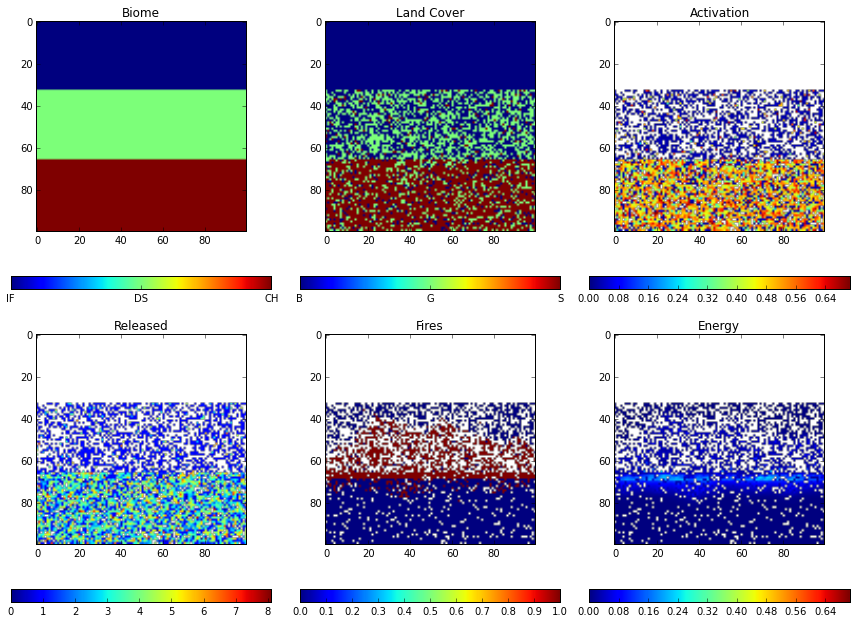

In [22]:
f = figure(figsize=(12,9))

f.add_subplot(231)
imshow(B); title('Biome')
cbar=colorbar(orientation='horizontal',ticks=[0,1,2])
cbar.ax.set_xticklabels(['IF','DS','CH'])

f.add_subplot(232)
imshow(L); title('Land Cover')
cbar=colorbar(orientation='horizontal',ticks=[0,1,2])
cbar.ax.set_xticklabels(['B','G','S'])

f.add_subplot(233)
not_nan = np.isfinite(A)
pct = np.percentile(A[not_nan],99)
imshow(A); title('Activation')
clim(0,pct)
colorbar(orientation='horizontal')

f.add_subplot(234)
imshow(R); title('Released')
cbar=colorbar(orientation='horizontal')

f.add_subplot(235)
_f = np.copy(F).astype(float)
_f[L==0] = np.nan
imshow(_f); title('Fires')
clim(0,1)
colorbar(orientation='horizontal')
#xticks([])

f.add_subplot(236)
imshow(E); title('Energy');
clim(0,pct)
colorbar(orientation='horizontal')

tight_layout()
savefig("/Users/Michael_Saha/Desktop/fire_sim.png",dpi=300)

In [21]:
pct

0.70520944136233421

In [18]:
np.array([0,0,0,1,1,1],dtype=bool).astype(float)

array([ 0.,  0.,  0.,  1.,  1.,  1.])